Enter path of image
Enter Threshold Value


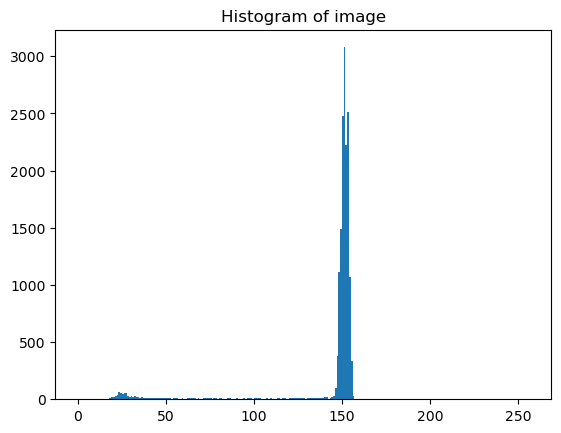

In [10]:
import cv2
from time import sleep
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
from matplotlib import pyplot as plt
import numpy as np
import time
import numpy as np
import pandas as pd

def threshold__img(img,threshold):
  binary = np.where(img < threshold, 0, 255).astype(np.uint8) # threshold
  return binary

path = input(print("Enter path of image"))
img = cv2.imread(path,0)
img = img.astype(np.uint8)
cv2.imshow("Img",img)
plt.hist(img.ravel(),256,[0,256]); plt.title("Histogram of image");

kernel = np.ones((5,5), np.uint8)

img_erosion = cv2.erode(img, kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)

# cv2_imshow(img)
# cv2_imshow(img_erosion)
# cv2_imshow(img_dilation)


binary=threshold__img(img_erosion.copy(),int(input(print("Enter Threshold Value"))))
# cv2_imshow(binary)

opening = cv2.morphologyEx(binary.copy(), cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening.copy(), cv2.MORPH_CLOSE, kernel)

# cv2_imshow(opening)
# cv2_imshow(closing)

binary=closing.copy()
cv2.imshow("Binary", binary)

In [11]:
#@title Using pytesseract for line and word segmentation { vertical-output: true, display-mode: "form" }
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
from pytesseract import Output
import cv2
from pytesseract.pytesseract import Output
from matplotlib import pyplot as plt
import numpy as np
import time

img_directory =None # To Undo work
word_flag=line_flag=False#-
line_images = []
word_images = []
level_wise_images = []
line=[]#-
word=[]#-
LEVEL1 = PAGE = 1
LEVEL2 = BLOCK = 2
LEVEL3 = PARAGRAPH =3
LEVEL4 = LINE = 4
LEVEL5 = WORD = 5



def psm_string(value):
  '''
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
			bypassing hacks that are Tesseract-specific.
  '''
  return str('--psm '+str(value))

def threshold_img(img,threshold =None):
  plt.hist(img.ravel(),256,[0,256]); plt.show() # change value accordingly
  if threshold is None:
    print("Enter threshold value:")
    threshold = int(input())
  binary = np.where(img < threshold, 0, 255) # threshold
  return binary

def indices_of_level(d):
  '''
  Level 1 Page
  Level 2 Block
  Level 3 Paragraph
  Level 4 Line
  Level 5 Word
  '''
  level ={} # dictionary for separating page,para,words.
  for i in range(1,6):
    # https://stackoverflow.com/questions/6294179/how-to-find-all-occurrences-of-an-element-in-a-list#:~:text=indices%20%3D%20%5Bi%20for%20i%2C%20x%20in%20enumerate(my_list)%20if%20x%20%3D%3D%20%22whatever%22%5D
    indices = [j for j, x in enumerate(d['level']) if x == i ]
    # print(i,":",indices,len(indices)) #-
    level[i]=indices
  return level

def cropped_image_to_data(img,d,labels,level_indices=None):
  cropped =[]
  hh,ww = img.shape
  for i in range(len(d['level'])):
    # https://stackoverflow.com/questions/60869306/how-to-simple-crop-the-bounding-box-in-python-opencv#:~:text=cropped_image%20%3D%20img%5BY%3AY%2BH%2C%20X%3AX%2BW%5D%0Aprint(%5BX%2CY%2CW%2CH%5D)%0Aplt.imshow(cropped_image)%0Acv2.imwrite(%27contour1.png%27%2C%20cropped_image)
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cropped_image = img[max(y-5,0):min(hh,y+h+5), max(x-5,0):min(x+w+5,ww)] # Added this line but tesseract accuracy decreases
    # cropped_image = img[y:y+h, x:x+w] # original line
    # print(labels[i])#-
    temp = labels[i].split("\n")
    # for i in temp[:-1]:#-
      # print(i)

    # cv2_imshow(cropped_image)
    # print()
    cropped.append(cropped_image)
    # print([x,y,w,h])

  return cropped

def labels_image_to_data(d):
  labels =[]
  for i in range(len(d['level'])):
    temp=[]
    for j in d:
      # print(j,d[j][i],end=" ")
      s1=str(j)
      s2=str(d[j][i])
      # https://stackoverflow.com/questions/35236759/printing-string-with-two-columns#:~:text=%27%7B0%3A10%7D%20%20%7B1%7D%27.format(s1%2C%20s2)
      temp.append('{0:15}  {1}'.format(s1, s2))

    labels.append('\n'.join(temp))
  return labels

def draw_boxes(img,d,level=0):
  name = ['PAGE','BLOCK','PARAGRAPH','LINE','WORD']
  # Not important below for loop
  n_boxes = len(d['level'])
  image = img.copy() # can change to binary.copy()
  for i in range(n_boxes):
    '''
    x1,y1 ------
    |          |
    |          |
    |          |
    --------x2,y2
    '''
    if d['level'][i]!=level:
      continue
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
  # print()
  # if level==0:
  #   print("All bounding boxes")
  # else:
  #   print("Level",level,"bounding boxes (",name[level-1],")")
  # cv2_imshow(image)
  return image.copy()

def save_levewise_images_into_direcotry(img,d,level_indices,cropped,parent_directory=None,level=0,labels=None):#-
  root = '/content/' # for google colab
  parent_directory = None

  # Making directory if not exists
  if parent_directory is None :
    try:
      parent_directory =str(os.getcwd())
    except:
      parent_directory = root
  elif not os.path.isdir(parent_directory):
    print('No directory exists')
    os.makedirs(parent_directory) # Not tested this line
  try:
    # Make directory to store images if not exist
    directory = os.path.join(parent_directory,'tesseract after processing')
    if not os.path.exists(directory):
      os.makedirs(directory)
    os.chdir(directory)

    # Making directory with date
    directory = os.path.join(directory,time.strftime("%Y-%m-%d"))
    if not os.path.exists(directory):
      os.makedirs(directory)
    os.chdir(directory)

    # Making directory for current image
    if len(os.listdir(directory)) == 0:
      directory = os.path.join(directory,str(1).zfill(3))
    else: # TO DO: I think this can handle folder upto 100 only then throws error
      all_folders = os.listdir(directory)
      all_folders= list(map(int, all_folders))
      all_folders.sort()
      latest = all_folders[-1]
      new = int(latest) + 1
      directory = os.path.join(directory,str(new).zfill(3))
    os.makedirs(directory)
    os.chdir(directory)

    global img_directory
    img_directory = directory # Saving for checkpoint
    # Storing original image
    # original = cv2.imread("/content/1.jpeg",0)
    original = img.copy()
    cv2.imwrite('images/img_22.png',original)
    # TO DO - If have multiple pages or PDF saving all pages or PDF


    if level ==0: # save all level images in tree shape
      # Storing end point of total levels
      end = len(d['level'])
      # print("Total of levels:",end)
      # print()

      # Saving all levels data in tree structure
      words =[]
      w = len(level_indices[5])
      lines =[]
      l = len(level_indices[4])
      paragraphs =[]
      p =len(level_indices[3])
      blocks =[]
      b =len(level_indices[2])
      pages =[]
      pg = len(level_indices[1])

      for i in range(end-1,-1,-1):
        # print(i)
        if i in level_indices[5]:
          words.append((w,i))
          w-=1
        elif i in level_indices[4]:
          lines.append((l,i,words))
          l-=1
          words = []
        elif i in level_indices[3]:
          paragraphs.append((p,i,lines))
          p-=1
          lines =[]
        elif i in level_indices[2]:
          blocks.append((b,i,paragraphs))
          b-=1
          paragraphs =[]
        elif i in level_indices[1]:
          pages.append((pg,i,blocks))
          pg-=1
          blocks =[]

      # Extracting tree structure
      for i in pages:
        # Creating folder for pages
        # Not tested for multiple pages
        page_directory = os.path.join(directory,str("Page No:"+str(i[0])))
        if not os.path.exists(page_directory):
          os.makedirs(page_directory)
        os.chdir(page_directory)

        cv2.imwrite(str("Page No:"+str(i[0])+".jpg"),cropped[i[1]])
        # print("Page No:",i[0],"index at",i[1],"total blocks",len(i[2]))
        for j in i[2]:
          block_directory = os.path.join(page_directory,str("Block No:"+str(j[0])))
          if not os.path.exists(block_directory):
            os.makedirs(block_directory)
          os.chdir(block_directory)

          cv2.imwrite(str("Block No:"+str(j[0])+".jpg"),cropped[j[1]])
          # print("\tBlock No:",j[0],"index at",j[1],"total paragraphs",len(j[2]))
          for k in j[2]:
            paragraph_directory = os.path.join(block_directory,str("Paragraph No:"+str(k[0])))
            if not os.path.exists(paragraph_directory):
              os.makedirs(paragraph_directory)
            os.chdir(paragraph_directory)

            cv2.imwrite(str("Paragraph No:"+str(k[0])+".jpg"),cropped[k[1]])
            # print("\t\tParagraph No:",k[0],"index at",k[1],"total lines",len(k[2]))
            for l in k[2]:
              line_directory = os.path.join(paragraph_directory,str("Line No:"+str(l[0])))
              if not os.path.exists(line_directory):
                os.makedirs(line_directory)
              os.chdir(line_directory)

              cv2.imwrite(str("Line No:"+str(l[0])+".jpg"),cropped[l[1]])
              # print("\t\t\tLine No:",l[0],"index at",l[1],"total words",len(l[2]))
              for m in l[2]:
                word_directory = os.path.join(line_directory,str("Word No:"+str(m[0])))
                if not os.path.exists(word_directory):
                  os.makedirs(word_directory)
                os.chdir(word_directory)

                # print("\t\t\t\t","Word No",m[0],"index at",l[1])
                cv2.imwrite(str("Word No:"+str(m[0])+".jpg"),cropped[m[1]])

      os.chdir(parent_directory)

    else: # save only that level images
      # creating directory for level
      name = ["Page","Block","Paragraph","Line","Word"]
      level_directory = os.path.join(directory,str(name[level-1]+" level only"))
      # print("Saving",name[level-1],"level only")
      if not os.path.exists(level_directory):
        os.makedirs(level_directory)
      os.chdir(level_directory)

      count =0
      global level_wise_images
      global word
      for i in range(len(d['level'])):
        if d['level'][i]==level:
          count+=1
          # print("\t",name[level-1], "No:",count,"index at",i)
          cv2.imwrite(str(name[level-1]+" No:"+str(count).zfill(2)+".jpg"),cropped[i])
          level_wise_images.append(cropped[i].copy())
          #-
          if word_flag:#-
            word.append(d['text'][i])
            # print(d['text'][i])
          #-

      os.chdir(parent_directory)

  except:
    os.chdir(parent_directory)
    print("Error Occurs while making directory")

def tesseract(path= None,img= None,psm = 3,image_to_boxes=False,threshold =True,level =0,directory=None,resize_dilation =False):
  if (path is None or path =="") and img is None:
    return 0
  try:
    global level_wise_images
    level_wise_images.clear() # clear list

    # preprocessing
    if path:
      original = cv2.imread(path,0)
    elif img is not None:
      original = img.copy()

    if threshold:
      binary = threshold_img(original.copy())
      binary = np.array(binary,dtype=np.uint8)
    else :
      binary = original.copy()
      binary = np.array(binary,dtype=np.uint8)

    # resize # can be removed
    if resize_dilation:
      kernel = np.zeros((3,3),np.uint8)
      dilation = cv2.dilate(255-binary,kernel,iterations = 15)
      binary = cv2.resize(255-dilation, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
      original = cv2.resize(original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # print("Original Image,Binary Image")
    # print("dtype:",original.dtype,binary.dtype)
    # print("shape:",original.shape,binary.shape)

    # For pytesseract input - https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type#:~:text=Additionally%2C%20please%20make%20sure%20the%20dtype%20is%20uint8(for%20gray)%20or%20bool(for%20binary).
    # print()
    # print("For tesseract to work dtype of image should be 'unit8'")

    # tesseract
    original_ =original.copy()
    binary_ = binary.copy()
    # https://stackoverflow.com/questions/20831612/getting-the-bounding-box-of-the-recognized-words-using-python-tesseract#:~:text=Use%20pytesseract.image_to_data()
    if not image_to_boxes:
       # https://stackoverflow.com/questions/44619077/pytesseract-ocr-multiple-config-options#:~:text=tesseract%2D4.0.0a%20supports%20below%20psm.%20If%20you%20want%20to%20have%20single%20character%20recognition%2C%20set%20psm%20%3D%2010
      try:
        d = pytesseract.image_to_data(binary_,output_type=Output.DICT,config=str("-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "+psm_string(psm)))
      except Exception as e:
        print("Error occureed in 'if not image_to_boxes:' block:",e)
    else:
      d = pytesseract.image_to_boxes(binary_,output_type=Output.DICT,config=str("-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "+psm_string(psm)))#-
    # print()
    # print("image_to_data dictionary:")
    for j,i in enumerate(d):#-
      if j <(len(d)-1):#-
        # print("\t",i,d[i],len(d[i]))
        pass

    if level ==0:
      for i in range(1,6):
        draw_boxes(original_.copy(),d,level=i)
    else:
      draw_boxes(original.copy(),d,level=level)

    # print()
    labels =labels_image_to_data(d)
    level_indices = indices_of_level(d)
    cropped=cropped_image_to_data(binary.copy(),d,labels,level_indices=level_indices) # Send appropriate image to function
    save_levewise_images_into_direcotry(img =original.copy(),d=d,level_indices=level_indices,cropped=cropped,parent_directory=None,level=level,labels=labels)#-
    # ipyplot.plot_images(cropped,labels=labels1,max_images=80,force_b64=True,img_width=200)

    return original,binary,original_,binary_,labels,cropped,d
  except:
    return 0

In [12]:
#@title Page to lines { vertical-output: true, display-mode: "form" }
# for line images

def pages_to_lines(img):
  global level_wise_images,line_images
  line_images.clear()
  line_flag=True #-
  word_flag=False #-
  tesseract(img=img,threshold=False,psm =12,level=LINE)
  line_images = level_wise_images.copy()
  level_wise_images.clear()

In [13]:
#@title Line to Words function { vertical-output: true, display-mode: "form" }
# for word images
def line_to_words(img):
  global level_wise_images,line_images,word_images
  line_flag =False#-
  word_images.clear()
  word_flag=True #-
  for i in line_images: # lines
    level_wise_images.clear()
    tesseract(img=img,psm =7,threshold =False,level=WORD)
    word_images.append(level_wise_images.copy())
  level_wise_images.clear()

In [14]:
#@title Word to Characters function { vertical-output: true, display-mode: "form" }
from skimage.filters import threshold_otsu

def word_to_characeters(img):
  #binarize the image, guassian blur will remove any noise in the image
  first_line = img.copy()

  # first_line = 255 -first_line
  thresh = threshold_otsu(first_line)
  binary = first_line > thresh
  # print(thresh)

  # find the vertical projection by adding up the values of all pixels along rows
  vertical_projection = np.sum(binary, axis=0)

  # plot the vertical projects
  # fig, ax = plt.subplots(nrows=2, figsize=(20,10))
  # plt.xlim(0, first_line.shape[1])
  # ax[0].imshow(binary, cmap="gray")
  # ax[1].plot(vertical_projection)

  height = first_line.shape[0]

  ## we will go through the vertical projections and
  ## find the sequence of consecutive white spaces in the image
  whitespace_lengths = []
  whitespace = 0
  index = 0
  index_=[]
  for vp in vertical_projection:

      if vp == height:
          whitespace = whitespace + 1
      elif vp != height:
          if whitespace != 0:
              whitespace_lengths.append(whitespace)
              index_.append(index)
          whitespace = 0 # reset whitepsace counter.
      index+=1
  # print("whitespaces:", whitespace_lengths)
  avg_white_space_length = np.mean(whitespace_lengths)
  # print("average whitespace lenght:", avg_white_space_length)

  # plt.imshow(binary,cmap='gray')
  # for xc in index_:
  #     plt.axvline(x=xc)

  ## find index of whitespaces which are actually long spaces using the avg_white_space_length
  whitespace_length = 0
  divider_indexes = []
  for index, vp in enumerate(vertical_projection):
      if vp == height:
          whitespace_length = whitespace_length + 1
      elif vp != height:
          if whitespace_length != 0 or whitespace_length > (avg_white_space_length):#change here
              divider_indexes.append(index-int(whitespace_length/2))
              whitespace_length = 0 # reset it



  for index, vp in reversed(list(enumerate(vertical_projection))):# for last word segmentation
      if vp == height:
          whitespace_length = whitespace_length + 1
      elif vp != height:
          if whitespace_length != 0 or whitespace_length > (avg_white_space_length):
              divider_indexes.append(index+int(whitespace_length/2))
              break
              whitespace_length = 0 # reset it

  # print(divider_indexes)

  # plt.imshow(binary,cmap='gray')
  # for xc in divider_indexes:
  #     plt.axvline(x=xc)

  # lets create the block of words from divider_indexes
  divider_indexes = np.array(divider_indexes)
  dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
  # fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
  l=[]
  for index, window in enumerate(dividers):
      # ax[index].axis("off")
      # ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")
      # cv2_imshow(first_line[:,window[0]:window[1]])
      l.append(first_line[:,window[0]:window[1]])
  return l


In [15]:
#@title Character image preprocessing { vertical-output: true, display-mode: "code" }
def vertical_projection_plt(img): # TODO: Not supporting multiple plots. Can use for single image at a time as a testing purpose
  # img - binary img
  from skimage.filters import threshold_otsu
  #binarize the image, guassian blur will remove any noise in the image
  # find the vertical projection by adding up the values of all pixels along rows
  vertical_projection = np.sum(img, axis=0)
  # plot the vertical projects
  fig, ax = plt.subplots(nrows=2, figsize=(10,5))
  plt.xlim(0, img.shape[1])
  ax[0].imshow(img, cmap="gray")
  ax[1].plot(vertical_projection)

def crop_image_remove_white(gray, pixel_value=255):
    # gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # OTSU threshold lines are added by me.
    (thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    gray = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]

    crop_rows = gray[~np.all(gray == pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows == pixel_value, axis=0)]
    # cv2_imshow(cropped_image)
    # print(cropped_image.shape)
    return cropped_image

def overlay_image_centre(img):
  # blank padding for words
  # grayscale image
  h, w = img.shape
  # print(h,w)

  # square_side = max(h,w)+10
  hh = h+120
  ww = w+100

  # load background image as white
  back = np.full((hh,ww),255,np.uint8)
  hh, ww = back.shape
  # print(hh,ww)

  # compute xoff and yoff for placement of upper left corner of resized image
  yoff = round((hh-h)/2)
  xoff = round((ww-w)/2)
  # print(yoff,xoff)

  # use numpy indexing to place the resized image in the center of background image
  result = back.copy()
  result[yoff:yoff+h, xoff:xoff+w] = img

  # view result
  # cv2_imshow(result)
  return result

def character_preprocessing(i):
  img = i.copy()
  # resize
  img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
  # otsu threshold
  (thresh, im_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY and cv2.THRESH_OTSU)
  gray = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
  # cv2_imshow(gray)

  #padding
  gray = crop_image_remove_white(gray)
  padding = overlay_image_centre(gray)
  kernel = np.ones((5,5), np.uint8)

  padding = cv2.erode(padding, kernel, iterations=1)
  # blur and dilation / inverting img for blur and dilation
  kernel = np.zeros((3,3),np.uint8)
  blur = cv2.bilateralFilter(255-padding,9,75,75)
  median = cv2.medianBlur(255-padding,5)
  dilation = cv2.dilate(median,kernel,iterations = 10)
  cv2.imshow(255-dilation)

  padding = overlay_image_centre(255-dilation)
  print("Shape of word after processing",padding.shape)

  cv2.imshow(cv2.resize(padding, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC))
  # show the output images
  return padding.copy()